Import libraries

In [28]:
import seaborn as sn
import pandas as pd
import json, os, io
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random
from collections import defaultdict

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.models import FastText

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from collections import OrderedDict
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from keras_preprocessing.text import tokenizer_from_json


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

Read dataset

In [3]:
root_path = os.path.join('..', '..', '..')
method = "staticEmbedding"

In [4]:
data = pd.read_csv(os.path.join(root_path, 'data', 'dataset.csv'))
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())

                                            filename  vul  \
0                                          uspses.py    0   
1                  _src_modules_json_schemas_2564.py    1   
2                                   cs_zone_facts.py    0   
3  _invenio_modules_oauthclient_views_client_2636.py    1   
4                                   test_builtins.py    0   

                                                func  
0  strId$ Copyright c numId$ numId$ sqlmap develo...  
1  strId$ strId$ strId$ strId$ strId$ strId$ strI...  
2  ANSIBLE_METADATA strId$ strId$ strId$ strId$ s...  
3  strId$ strId$ strId$ make_handler disconnect_h...  
4  class SimpleTestCase @setup strId$ strId$ def ...  


Explore data

In [5]:
data = data.dropna(subset=["func"])

In [6]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

Maximum number of words: 510


In [7]:
vc = data["vul"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

vul
0    3168
1     997
Name: count, dtype: int64
Percentage:  31.470959595959595 %
2


In [8]:
data = pd.DataFrame(({'text': data['func'], 'label': data['vul']}))
#data = data[0:100]
data.head()

,text,label
0,strId$ Copyright c numId$ numId$ sqlmap develo...,0
1,strId$ strId$ strId$ strId$ strId$ strId$ strI...,1
2,ANSIBLE_METADATA strId$ strId$ strId$ strId$ s...,0
3,strId$ strId$ strId$ make_handler disconnect_h...,1
4,class SimpleTestCase @setup strId$ strId$ def ...,0


Create word embedding vectors

In [9]:
def stringToList(string):
    codeLinesList = []
    for line in string.split():
        codeLinesList.append(line)
    return codeLinesList

allTokens = []
for seq in data["text"]:
    listSeq = stringToList(seq)
    allTokens.append(listSeq)

data["Tokens"] = allTokens
data.head()
#data["Tokens"][0]

,text,label,Tokens
0,strId$ Copyright c numId$ numId$ sqlmap develo...,0,"[strId$, Copyright, c, numId$, numId$, sqlmap,..."
1,strId$ strId$ strId$ strId$ strId$ strId$ strI...,1,"[strId$, strId$, strId$, strId$, strId$, strId..."
2,ANSIBLE_METADATA strId$ strId$ strId$ strId$ s...,0,"[ANSIBLE_METADATA, strId$, strId$, strId$, str..."
3,strId$ strId$ strId$ make_handler disconnect_h...,1,"[strId$, strId$, strId$, make_handler, disconn..."
4,class SimpleTestCase @setup strId$ strId$ def ...,0,"[class, SimpleTestCase, @setup, strId$, strId$..."


In [10]:
# word embedding 
embeddings_index = {}
f = open('w2v_embeddings.txt', encoding="utf-8")
for line in f:    
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs   
f.close() 

dim = 200

In [11]:
tokenizer_obj = Tokenizer()   
tokenizer_obj.fit_on_texts(data["Tokens"])

tokenizer_json = tokenizer_obj.to_json()
tokenizerFile = 'w2v_tokenizer.json'

with io.open(tokenizerFile, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

with open(tokenizerFile) as f:
    dataTokenizer = json.load(f)
    tokenizer_obj = tokenizer_from_json(dataTokenizer)

sequences = tokenizer_obj.texts_to_sequences(data["Tokens"])
word_index = tokenizer_obj.word_index

lines_pad = pad_sequences(sequences, padding = 'post', maxlen = max_length)

num_words = len(word_index) + 1 # +1 for the unknown-zeros

embedding_matrix = np.zeros((num_words, dim))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Split to train-val-test

In [12]:
val_ratio = 0.10

In [13]:
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

In [14]:
train_val_x, test_x, train_val_y, test_y = train_test_split(lines_pad, data['label'], test_size=val_ratio, random_state=shuffle_seeder, stratify=data['label'])
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=val_ratio, random_state=shuffle_seeder, stratify=train_val_y)
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

In [15]:
# rename
x_train = train_x
x_val = val_x
x_test = test_x

In [16]:
y_train = np.array(train_y)
y_val = np.array(val_y)
y_test = np.array(test_y)

Deep Learning Models

In [17]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

In [18]:
def buildCnn(max_len, top_words, dim, optimizer, seed, embedding_matrix, multi, n_outputs):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 1, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    if multi == False:
        cnn_model.add(Dense(n_outputs, activation = 'sigmoid'))
        cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=[f1_metric])
    else: 
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    return cnn_model

    
def buildLstm(max_len, top_words, dim, optimizer, seed, embedding_matrix, multi, n_outputs):
    model=Sequential()
    #model.add(Embedding(input_dim=top_words+1, output_dim=dim, input_length=None, mask_zero=True))
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    #model.add(SimpleRNN(300, dropout=0.3, stateful=False))
    model.add(LSTM(100, dropout=0.2, return_sequences=True, stateful=False))
    model.add(LSTM(50, dropout=0.1, stateful=False))
    #model.add(Bidirectional(LSTM(300, dropout=0.3, stateful=False)))
    #model.add(GRU(300, dropout=0.3, stateful=False))
    model.add(Activation('relu')) #dropout=0.2, recurrent_dropout=0.2, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)
    model.add(BatchNormalization())
    if multi == False:
        model.add(Dense(n_outputs, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_metric])  
    else: 
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    return model

In [19]:
userModel = "cnn"

# hyperparams
n_epoch = 100
batch_size = 64
optimizer = 'adam'
patience = 10

In [20]:
model_variation = "w2v_cnn"

Train model

In [21]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

if userModel == "cnn":
    myModel = buildCnn(max_length, num_words, dim, optimizer, seed, embedding_matrix, False, 1) 
elif userModel == "lstm":
    myModel = buildLstm(max_length, num_words, dim, optimizer, seed, embedding_matrix, False, 1)
print("model summary\m",myModel.summary())

csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=patience)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = n_epoch, batch_size = batch_size, verbose=1, callbacks=[csv_logger,es,mc])

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2136600   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         25728     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,162,457
Trainable params: 25,857
Non-trainable params: 2,136,600
_________________________________________________________________
model summary\m None
Epoch 1/100
43/53 [=======================>......] - ETA: 0s - loss: 0.448

Load best model

In [22]:
myModel.load_weights("best_model.h5")

Results on the validation set

In [23]:
print(classification_report(y_val, (myModel.predict(x_val) > 0.5).astype("int32")))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       285
           1       0.84      0.90      0.87        90

    accuracy                           0.93       375
   macro avg       0.90      0.92      0.91       375
weighted avg       0.94      0.93      0.93       375



Make predictions on the testing set and compute evaluation metrics

In [24]:
predScores = myModel.predict(x_test)
predictions = (predScores > 0.5).astype("int32")

print(classification_report(y_test, predictions))

14/14 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       317
           1       0.86      0.79      0.82       100

    accuracy                           0.92       417
   macro avg       0.90      0.87      0.88       417
weighted avg       0.92      0.92      0.92       417



TP= 79
TN= 304
FP= 13
FN= 21
Accuracy:91.85%
Precision:85.87%
Recall:79.00%
Roc_Auc score:87.45%
F1 score:82.29%
F2 score:80.28%


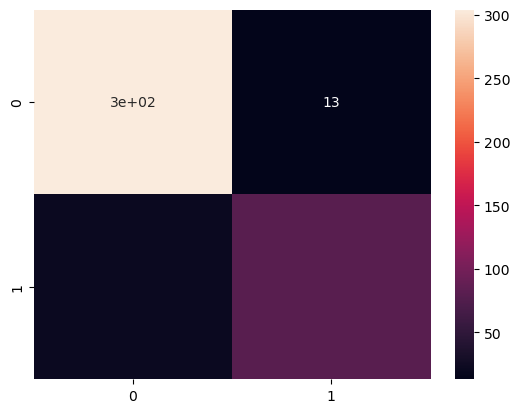

In [25]:
accuracy=accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions)
recall=recall_score(y_test, predictions)
roc_auc=roc_auc_score(y_test, predictions)
f1=f1_score(y_test, predictions)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(y_test, predictions)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))

Export classification report

In [26]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(shuffle_seeder))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{shuffle_seeder}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [29]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method, str(shuffle_seeder))
for filename in os.listdir(results_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(results_folder, filename)
        with open(csv_file_path, "r", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for metric, value in row.items():
                    cumulative_metrics[metric] += float(value)
        count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)

{'accuracy': 0.9184652278177458, 'precision': 0.8586956521739131, 'recall': 0.79, 'f1': 0.8229166666666666, 'f2': 0.8028455284552846, 'roc_auc': 0.8744952681388013}
